In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy.constants as const
from scipy import ndimage
from scipy.spatial.transform import Rotation
from numpy import linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib.colors as mpl_colors
import matplotlib as mpl

from stl import mesh
from mpl_toolkits import mplot3d

In [3]:
import sys, os
sys.path.insert(1, '../MesonMagMapping/PrettyPlotTools/')
import ParticlePlottingFunctions as ppf
import AdiabaticEquations as Adi
%load_ext autoreload
%autoreload 2

In [4]:
#importing physical constants that are useful from scipy.constants
m_p = const.physical_constants['proton mass energy equivalent in MeV'][0]
m_n = const.physical_constants['neutron mass energy equivalent in MeV'][0]
c = const.c #m/s
hbar = const.hbar

mu_n = const.physical_constants['neutron mag. mom.'][0] #J T^-1
g_n = const.physical_constants['neutron mag. mom. to nuclear magneton ratio'][0]
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1, negative

In [5]:
#addes labels to contour lines nicely
def fmt_lable(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"$k$ = {s}" if plt.rcParams["text.usetex"] else f"$k$ = {s}"

#returns the index of the closest value to N in a list generated 
#from the unique values in a given column of a df
def FindClosest(df, N, val):
    dfun = df[val].unique()
    # print(len(dfun))
    difference_array = np.absolute(dfun-N)
    index = difference_array.argmin()
    return index

In [6]:
"""
Same as above, but with custom axis tick labels
B_arr - array of B values to plot [T]
dx_arr - array of dx value to plot [m]

"""   
def range_forK_customAxis(particleData, Vmin=None, Vmax=None, R_G=False):
    k_array = np.empty((0, 3))
    v_vec = np.array([8, 0, 0])
    
    B_3D_arr, r_3D_arr
    
    # for B in B_arr:
    #     for dbdx in dbdx_arr:
    #         val = Adi.K_equ_dbdx(B, dbdx, vn)
    #         k_array = np.append(k_array, np.array([[B, dbdx, val]]), axis=0)

    for i in range(len(particleData)-1):
            B_1 = particleData[['Bx', 'By', 'Bz']][i]
            B_2 = particleData[['Bx', 'By', 'Bz']][i+1]
            
            val = Adi.K_equ3_14(v_vec, B_3D_arr[i], B_2, r_1, r_2, k_inf_set=False)
            B = B_1
            dx = (r_2 - r_1)
            bdbdx = 1
            
            k_array = np.append(k_array, np.array([[B, dx, val]]), axis=0)
        
    df = pd.DataFrame(k_array, columns = ['B','dx','k'])
    df["B"] = df["B"]*1e6 #convert to uT
    df["dx"] = df["dx"]*100 #convert to cm
    
    return df

In [7]:
'''
10 uT/cm -> 10e-6 uT/cm -? 10e-4 uT/m
'''

'\n10 uT/cm -> 10e-6 uT/cm -? 10e-4 uT/m\n'

In [103]:
#spaced evenly in log10 space
n = 50
B_arr = np.logspace(np.log10(1e-6), np.log10(100e-6), num=n, base=10.0)
# B_arr = np.linspace(1e-6, 500e-6, num=n)

db = np.linspace(10e-4, 100e-4, n) #T/m
#this implies that all my dx = 1 m -> could change in the future
angle = np.linspace(1, 90, n)

In [105]:
# convert to 2d matrices
#just tile the B_arr from 1D to 2D, so for each X,Y combo, you cover all the Zs
Z = np.tile(B_arr, (n, 1))
# print(Z)

X, Y = np.meshgrid(db, angle)    # 50x50

orginalShape = X.shape
NT = np.product(orginalShape)

def B2(row, dim):
    '''
    get the second magnetic field for a given component after a rotation
    of Angle [deg]
    '''
    vec1 = np.array([row[1]+row[2],row[3], row[4]])
    # print(vec1)
    theta = np.radians(row[0])
            
    axis = [0,0,1] #z axis
    axis = axis / LA.norm(axis)  # normalize the rotation vector first
    rot = Rotation.from_rotvec(theta * axis)

    vec2 = rot.apply(vec1)  
    # print(vec2)
    if dim==0:
        comp = vec2[0]
    elif dim==1:
        comp = vec2[1]
    else:
        comp = vec2[2]
    return comp 


data = {
    "Angle": np.reshape(Y,NT), #deg
    "db": np.reshape(X,NT), # T/m
    "B1_x": np.reshape(Z,NT), #T
    "B1_y": np.reshape(Z,NT)*0, #T
    "B1_z": np.reshape(Z,NT)*0, #T
    }

Bdata = pd.DataFrame(data)

# display(Bdata)

In [106]:
Bdata['B2_x'] = Bdata.apply(B2, dim=0, axis=1)
Bdata['B2_y'] = Bdata.apply(B2, dim=1, axis=1)
Bdata['B2_z'] = Bdata.apply(B2, dim=2, axis=1)

# Bdata.columns

In [107]:
def Bmagnitude(row, B1=True):
    '''
    Returns the magnitude of the B field vector.
    assumes the row of the data frame is in the form and order:
    ['Angle', 'db', 'B1_x', 'B1_y', 'B1_z', 'B2_x', 'B2_y', 'B2_z']
    '''
    
    if B1:
        Bmag = LA.norm(np.array([row[2],row[3], row[4]]))
    else:
        Bmag = LA.norm(np.array([row[5],row[6], row[7]]))

    return Bmag

def df_K_equ3_14_turn(row, vn=8, k_inf_set=False):
    '''
    assumes the row of the data frame is in the form and order:
    ['Angle', 'db', 'B1_x', 'B1_y', 'B1_z', 'B1', 'B2_x', 'B2_y', 'B2_z', 'B2']
    '''
    
    v_vec = np.array([vn, 0, 0])
    
    dx=1
    
    B_1 = np.array([row[2],row[3], row[4]])
    B_2 = np.array([row[6],row[7], row[8]])
    r_1 = np.array([0, 0, 0]) 
    r_2 = np.array([dx, 0, 0])

    return Adi.K_equ3_14(v_vec, B_1, B_2, r_1, r_2, k_inf_set=k_inf_set)

In [108]:
#get the magnitude of the magnetic fields for graphing
B1_mag = Bdata.apply(Bmagnitude,  axis=1, B1=True)
B2_mag = Bdata.apply(Bmagnitude,  axis=1, B1=False)

Bdata['B1'] = B1_mag
Bdata['B2'] = B2_mag

#reorder the columns
Bdata = Bdata.reindex(columns=['Angle', 'db', 'B1_x', 'B1_y', 'B1_z', 'B1', 'B2_x', 'B2_y', 'B2_z', 'B2'])

#and calculate k for all the values
Bdata['k'] = Bdata.apply(df_K_equ3_14_turn, axis=1)

In [109]:
# len(Bdata[Bdata['Angle']==1]['db'])

In [110]:
#get all the columns of the df to plot back into 2D numpy arrays
k_arr = np.reshape(Bdata['k'].to_numpy(), orginalShape)
B1_arr = np.reshape(Bdata['B1'].to_numpy(), orginalShape)
B2_arr = np.reshape(Bdata['B2'].to_numpy(), orginalShape)
angle_arr = np.reshape(Bdata['Angle'].to_numpy(), orginalShape)
db_arr = np.reshape(Bdata['db'].to_numpy(), orginalShape)

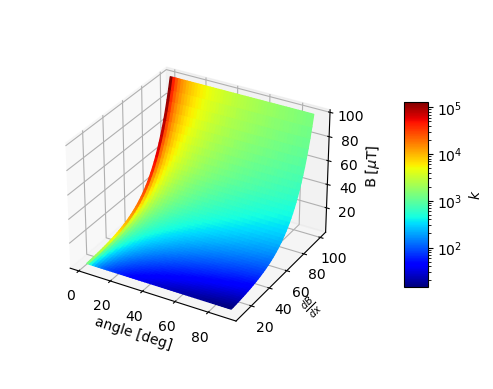

In [113]:
# %matplotlib widget
%matplotlib inline

# https://stackoverflow.com/questions/72228196/4d-plot-surface-doesnt-display-the-colors-of-my-4th-dimension

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

cmap = mpl.cm.jet
# norm = mpl_colors.Normalize(vmin=np.amin(k_arr), vmax=np.amax(k_arr))
#log color bar so you can actually see things
norm = mpl_colors.LogNorm(vmin=np.amin(k_arr), vmax=np.amax(k_arr))

# pl_colors.LogNorm(
# create face colors from a colormap and normalized color values
fcolors = cmap(norm(k_arr))
scamap = cm.ScalarMappable(cmap=cmap, norm=norm)

#actually tells you the args for plot_surface()
# https://www.studytonight.com/matplotlib/matplotlib-3d-surface-plot-plot_surface-function

ax.plot_surface(angle_arr, db_arr*1e6/100, B1_arr*1e6, facecolors=fcolors, cmap=cmap, shade=False)
               # rcount=50, ccount=50) #number of rows/col to use, default is 50
fig.colorbar(scamap, ax=ax, fraction=0.1, shrink=.5, aspect=8, label='$k$')

ax.set_xlabel('angle [deg]')
ax.set_ylabel("$\\frac{dB}{dx}$ ") #[$\mu$T/cm]
ax.set_zlabel("B [$\mu$T]")

# plt.tight_layout()s
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.show()

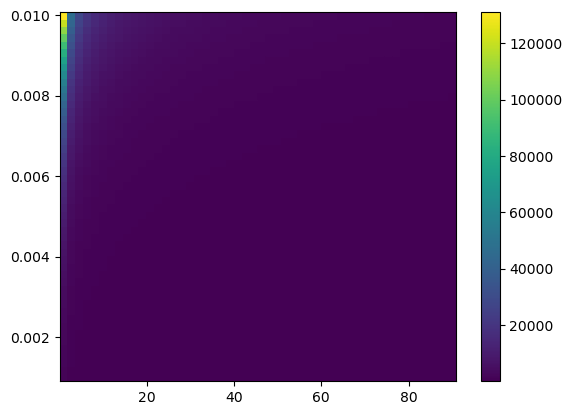

In [114]:
#just checking the 2d version matches up
fig, ax = plt.subplots()

cax = plt.pcolor(angle_arr, db_arr, k_arr)
cbar = fig.colorbar(cax)
plt.show()

## Just trying to get my constants straight

In [24]:
m_p = const.physical_constants['proton mass energy equivalent in MeV'][0]
m_n = const.physical_constants['neutron mass energy equivalent in MeV'][0]
c = const.c #m/s
hbar = const.hbar # J Hz^-1

g_n = const.physical_constants['neutron g factor'][0] #unitless, negative
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1, negative

gamma = const.physical_constants['neutron mag. mom. to nuclear magneton ratio'][0] #unitless

mu_n = const.physical_constants['neutron mag. mom.'][0] #J T^-1
mu_N = const.physical_constants['nuclear magneton'][0] #J T^-1

In [16]:
print(gamma_n)

183247171.0


In [17]:
2/hbar * mu_n

-183247170.81036282

In [31]:
g_n*mu_N / hbar

-183247170.82979915

In [25]:
gamma

-1.91304273

In [28]:
g_n/2

-1.913042725

In [35]:
hbar*2*np.pi

6.62607015e-34